In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, silhouette_score
from sklearn import preprocessing
from random import shuffle
import seaborn as sns

## Loading the data

In [2]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv')
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


## Cleaning the data
As explained in [this notebook](https://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb), we need to remove some bogus data. When there are less than 22 dyads for a specific referee, it means he or she hasn't met 22 players. Thus it means he or she didn't referee a match in one of the four leagues we study here. Thus we remove its entries.

In [3]:
ref_counts = df.refNum.value_counts()
valid_refs = ref_counts[ref_counts >= 22]
filtered = df[df.refNum.isin(valid_refs)].copy()

In [4]:
def count_values(series):
    return series.value_counts().count()

old_nb_players = count_values(df.playerShort)
new_nb_players = count_values(filtered.playerShort)
delta = old_nb_players - new_nb_players

print('After filtering, we lose {} players, which represents {:.2f}% of the players.'.format(
        delta, delta/old_nb_players*100))
print('We still have N={} players in our dataset, which is enough.'.format(new_nb_players))

After filtering, we lose 42 players, which represents 2.05% of the players.
We still have N=2011 players in our dataset, which is enough.


In [5]:
old_nb_refs = count_values(df.refNum)
delta = old_nb_refs - count_values(filtered.refNum)

print('After filtering, we lose {} referees, which represents {:.2f}% of the referees.'.format(
        delta, delta/old_nb_refs*100))

After filtering, we lose 2830 referees, which represents 89.93% of the referees.


## Building the features
Since we're interested in predicting the skin color of a player, we'll group the data by player. First we can check that the `playerShort` field uniquely determines a player since there are no duplicates when we index by `playerShort` and `refNum`.

In [6]:
filtered.set_index(['playerShort', 'refNum']).index.is_unique

True

In [7]:
filtered.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')

We want to group the entries by player. Therefore we need to find a way to aggregate the data in a meaningful way to create good features. Let's have a look at the data we have and specify what we want to do with each column:
* __player__: we could use the first and/or last name of a player as a feature. Adding it as a feature using dummy variables would add too many dimensions. Processing it in a more complicated would take too much time so we ignore it for now.

* __club__, __leagueCountry__: we encode these as a categorical feature
* __birthday__: we drop it since it should be independent of the skin color
* __height__, __weight__: we keep them as is since due to genetics skin color and height/weight could be correlated
* __position__: we encode it as a categorical feature
* __games__, __victories__, __ties__, __defeats__, __goals__: we sum these for each player
* __yellowCards__, __yellowReds__, __redCards__: likewise
* __photoID__: just a file name, not useful
* __rater1__, __rater2__: we create a new feature which is the mean of these two
* __refNum__, __refCountry__, __Alpha_3__: we drop them since it's not related to the player and is redundant with the IAT and exp scores
* __meanIAT__, __seIAT__: we average them so that we know, on average, how biased were the referees the player met (note that for the standard error, we can't just average it)
* __meanExp__, __seExp__: likewise
* __nIAT__, __nExp__: we drop them, they could be useful to estimate the accuracy of the IAT and Exp scores though

First, we compute the average skin color rating of each player. We can also remove the players for which we don't have a rating of their skin color since we miss the label.

In [8]:
filtered['skinColor'] = (filtered.rater1 + filtered.rater2) / 2
filtered.dropna(subset=['rater1', 'rater2'], inplace=True)

print('We now have N={} players.'.format(count_values(filtered.playerShort)))

We now have N=1572 players.


Do we want to drop the samples for which we don't have all the data? As seen in the cell below, we only lose 159 players if we use `dropna()`, this is reasonable and should not impact our learning too much. Thus we drop these rows.

In [9]:
count_values(filtered.dropna().playerShort)

1413

In [10]:
filtered.dropna(inplace=True)

As seen in the cells below. Encoding the league using dummy variables will create 4 features. This is not a problem. Likewise for the position of the player (12 distinct values). However, there are 117 different clubs in our dataset though, so encoding the club as dummy variables would create a large number of feature. We need to keep this in mind and see whether it's impacting negatively our classifier.

In [11]:
count_values(filtered.leagueCountry)

4

In [12]:
count_values(filtered.position)

12

In [13]:
count_values(filtered.club)

91

We now group by and aggregate the data by player. We also encode the categorical features as dummy variables. Finally, we create two dataframes, X which is our set of samples and y which are the corresponding labels. We still need to discretize the y labels into multiple classes (skin tones). We'll do it later, let's first analyze a bit our dataset.

In [14]:
averageSE = lambda x: np.sqrt((x ** 2).mean())

# TODO : check if we want to add the club as a feature
columns_to_keep = {'leagueCountry': 'first', 'height': 'first', 'weight': 'first',
                   'position': 'first', 'games': 'sum', 'victories': 'sum', 'ties': 'sum', 'defeats': 'sum',
                   'goals': 'sum', 'yellowCards': 'sum', 'yellowReds': 'sum', 'redCards': 'sum', 'skinColor': 'first',
                   'meanIAT': 'mean', 'seIAT': averageSE, 'meanExp': 'mean', 'seExp': averageSE}
data = filtered[list(columns_to_keep.keys()) + ['playerShort']]
data = data.groupby('playerShort').agg(columns_to_keep)
data = pd.get_dummies(data, columns=['leagueCountry', 'position'])

y = data.skinColor
X = data.drop('skinColor', axis=1)

## Analyzing our freshly created dataset
Do we need to normalize numerical features? For a random forests classifier the answer is no. By default, Scikit-Learn uses the Gini impurity function as a criterion for the best split at each level of a tree. Any monotonic pre-processing of the features won't have any effect on the splits of the tree. See [this quora topic](https://www.quora.com/Should-inputs-to-random-forests-be-normalized) and [this page](http://jordiinglada.net/wp/2015/04/22/should-we-always-normalize-image-features-before-classification/) for more details.

As seen below, we have $N=1413$ samples and $D=30$ features.

In [15]:
X.shape

(1413, 30)

Our features are the following:

In [16]:
X.columns

Index(['seIAT', 'height', 'seExp', 'yellowReds', 'goals', 'ties', 'redCards',
       'yellowCards', 'games', 'victories', 'meanIAT', 'weight', 'defeats',
       'meanExp', 'leagueCountry_England', 'leagueCountry_France',
       'leagueCountry_Germany', 'leagueCountry_Spain',
       'position_Attacking Midfielder', 'position_Center Back',
       'position_Center Forward', 'position_Center Midfielder',
       'position_Defensive Midfielder', 'position_Goalkeeper',
       'position_Left Fullback', 'position_Left Midfielder',
       'position_Left Winger', 'position_Right Fullback',
       'position_Right Midfielder', 'position_Right Winger'],
      dtype='object')

**We have a massive class imbalance!** If we discretize our skin color into 2 classes,  We have more than 5 times more white players than black players in the dataset. Even with 5 classes, two of them contain most of the samples. We'll have to be aware of this issue when splitting our dataset and also while training and evaluating our model.

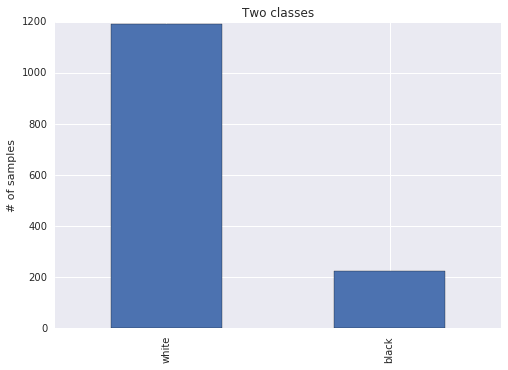

In [17]:
sns.set_style('darkgrid')
classes = pd.cut(y, bins=2, labels=['white', 'black'])
classes.value_counts().sort_index().plot(kind='bar', title='Two classes')
plt.ylabel('# of samples')
plt.show()

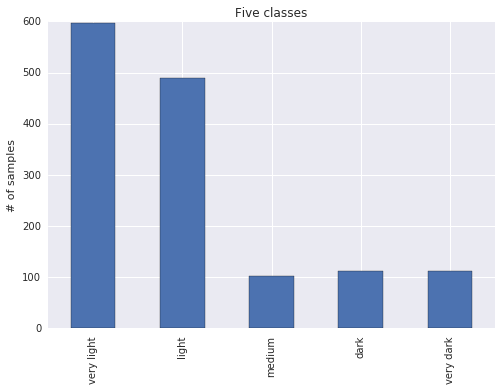

In [18]:
classes = pd.cut(y, bins=5, labels=['very light', 'light', 'medium', 'dark', 'very dark'])
classes.value_counts().sort_index().plot(kind='bar', title='Five classes')
plt.ylabel('# of samples')
plt.show()

## Fitting the model

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, make_scorer, cohen_kappa_score

We first split our dataset into a train set and a test set. The split is random, samples are shuffled. The first one will be used to fit and evaluate the model using cross-validation. The test set will be used to evaluate our model at the very end. We will ignore the test set so we don't bias the final score of our model!

Because of the class imbalance, we use a stratified cut to make sure that the proportion of the classes is the same in both the train and the test set.

### Without undersampling (class imbalance)

In [20]:
y_bin = pd.cut(y, bins=2, labels=np.arange(2))

In [21]:
X_tr, X_te, y_tr, y_te = train_test_split(np.array(X), np.array(y_bin), test_size=0.15,
                                          random_state=1337, stratify=y_bin)

In [22]:
rf = RandomForestClassifier(class_weight={0: 1.0, 1: 6.0})
params = {'n_estimators': np.arange(5,20), 'class_weight':[{0: 1.0, 1: 6.0}]}
clf = GridSearchCV(rf, param_grid=params, n_jobs=1, cv=5)#, scoring=make_scorer(cohen_kappa_score))
clf.fit(X_tr, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight={0: 1.0, 1: 6.0},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'class_weight': [{0: 1.0, 1: 6.0}]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [23]:
clf.best_score_

0.83846794338051622

In [24]:
y_pred = clf.predict(X_te)

In [25]:
clf.score(X_te, y_te)

0.83490566037735847

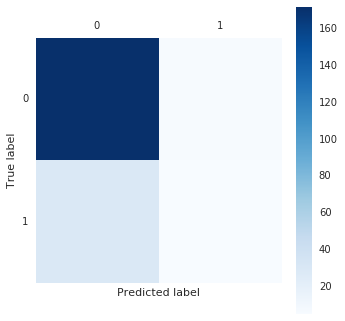

In [26]:
sns.set_style('dark')
cm = confusion_matrix(y_te, y_pred, labels=None)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### With undersampling (much less samples but no imbalance)

In [27]:
white_indices = y_bin[y_bin == 0].index
sample_size = sum(y_bin == 1)
random_indices = np.random.choice(white_indices, sample_size, replace=False)
indices = np.concatenate([random_indices, y_bin[y_bin == 1].index])

In [28]:
X_tr, X_te, y_tr, y_te = train_test_split(np.array(X.loc[indices]), np.array(y_bin.loc[indices]), test_size=0.15,
                                          random_state=1337)

In [29]:
rf = RandomForestClassifier()
params = {'n_estimators': np.arange(5,20)}
clf = GridSearchCV(rf, param_grid=params, n_jobs=1, cv=5)
clf.fit(X_tr, y_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [30]:
clf.best_score_

0.66842105263157892

In [31]:
y_pred = clf.predict(X_te)

In [32]:
clf.score(X_te, y_te)

0.67647058823529416

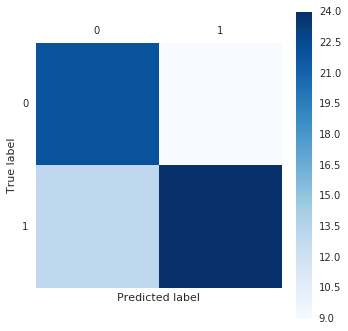

In [33]:
sns.set_style('dark')
cm = confusion_matrix(y_te, y_pred, labels=None)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Exercise 2
_Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette score where players with dark and light skin colors belong to different clusters? Discuss the obtained results._

As asked, the data will be grouped by player and the columns containing information about the referee will be aggregated. First, let's get a fresh copy of the data and drop NaN values.

In [34]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv')
df.dropna(inplace=True)

Now, as seen in exercise 1, the classes are completely imbalanced. Because of this, basic scoring functions such as F1 cannot be used, as they would output incorrect accuracy. As an example, we can group the data by player, use a binary representation of the skin color (black & white) and check what accuracy we can acheive by predicting that every player is white.

In [35]:
# Compute the skin tone
# If skinTone <= 0.5 --> 0 (white)
# If skinTone > 0.5 --> 1 (black)
skinTone = (df.rater1 + df.rater2)/2
df['skinTone'] = round(skinTone)

truth = df.groupby('playerShort').first()['skinTone']

1 - f1_score(truth, np.ones(len(truth)))

0.724179829890644

We reached 72% precision without even training any algorithm ! Of course, this scoring function can't be used. Let's try something else.

In [36]:
def ber(truth, predicted, classes):
    errors = 0
    lengths = [len(truth[truth == c]) for c in classes]
    n = len(truth)
    
    for c in classes:
        classError = 0  # Use a second variable to avoid float precision error when doing += 1/n
        for i in range(n):
            if predicted[i] != truth[i] and c == truth[i]:
                classError += 1
        errors += classError/lengths[c]
            
    return errors/len(classes)

# Make this a scorer function
ber_scorer = make_scorer(ber, greater_is_better=False)

In [37]:
1 - ber(truth, np.ones(len(truth)), [0, 1])

0.5

Ok this is better ! Using the Balanced Error Rate (http://icapeople.epfl.ch/mekhan/pcml15/project-2/objectDetection.html) we know obtain a precision of 50% when predicting that everybody is black. Now let's move to the problem itself. Group the data by player and average referee-related columns.

In [38]:
# Aggregate referees variables after grouping by players
tosum = ['playerShort', 'yellowCards', 'yellowReds', 'redCards', 'games', 'ties', 'goals']
tocollect = ['playerShort']
tomean = ['playerShort', 'meanIAT', 'meanExp']
tomeanstd = ['playerShort', 'seIAT', 'seExp']

group1 = df[tosum].groupby('playerShort').sum()
group2 = df[tocollect].groupby('playerShort').first()
group3 = df[tomean].groupby('playerShort').mean()
group4 = df[tomeanstd].groupby('playerShort').agg(lambda x: np.sqrt(np.mean(x**2)/len(x)))

agg = pd.concat([group1, group2, group3, group4], axis=1)

agg.head(5)

,yellowCards,yellowReds,redCards,games,ties,goals,meanIAT,meanExp,seIAT,seExp
playerShort,,,,,,,,,,
aaron-hughes,19,0,0,654,179,9,0.346459,0.494575,0.000257,0.002137
aaron-hunt,42,0,1,336,73,62,0.348818,0.449220,0.000055,0.000252
aaron-lennon,11,0,0,412,97,31,0.345893,0.491482,0.000126,0.000887
aaron-ramsey,31,0,1,260,42,39,0.346821,0.514693,0.002757,0.010251
abdelhamid-el-kaoutari,8,4,2,124,40,1,0.331600,0.335587,0.001037,0.003851


You can see that we keep some player-related variables such has yellowCards, redCards, etc. This is because this also somewhat related to the referees, even if it is averaged, and we don't want to loose too much data. It if it useless, the feature engineering algorithm will remove them anyway.

Let's now define a few other functions that we will use with KMeans.

In [39]:
# Change the order of the features
def shuffle_features(X):
    index = X.columns.values.tolist()
    shuffle(index)
    return X[index]

In [40]:
# Works with tuples (score, silhouette, fit, features)
def compare_and_swap(best, current):
    if current[0] > best[0]:
        print("=== Current Best ===")
        print("Best accuracy: " + str(current[0]))
        print("Silhouette score: " + str(current[1]))
        print("Features: " + str(current[3]))
        print("====================\n")
        return current
    else:
        return best

In [41]:
# Scale the between 0 and 1
def scale(X):
    columns = X.columns
    index = X.index
    X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(agg))
    X.columns = columns
    X.index = index
    return X

Redefine the skin tone, but this time, round half up. This give a more balanced distribution. It is still very imbalanced.

In [42]:
df['skinTone'] = (df.rater1 + df.rater2)/2
skinTone = df.groupby('playerShort').first()['skinTone']
skinTone[skinTone >= 0.5] = 1
skinTone[skinTone < 0.5] = 0

Compute the clusters centers using KMeans. The algorithm is run multiple times with one feature removed at each iteration. When no feature remains, the algorithm is restarted with all the feature in randomized order.

In [43]:
agg = scale(agg)
score = (0, 0, None, [])  # (accuracy, silhouette score, kmeans fit, selected features)

for i in range(50):
    data = shuffle_features(agg)
    
    while (len(data.columns) > 1):
        data = data[data.columns[:-1]]
        
        kmeans = KMeans(2)
        fit = kmeans.fit(data)

        silhouette = silhouette_score(data, fit.labels_)
        newScore = (1 - ber(skinTone, fit.labels_, [0, 1]), silhouette, fit, data.columns.values)
        score = compare_and_swap(score, newScore)

=== Current Best ===
Best accuracy: 0.48663911845730023
Silhouette score: 0.297767895442
Features: ['meanExp' 'games' 'meanIAT' 'yellowReds' 'yellowCards' 'redCards' 'goals'
 'seExp' 'seIAT']

=== Current Best ===
Best accuracy: 0.5133608815426998
Silhouette score: 0.306319036171
Features: ['meanExp' 'games' 'meanIAT' 'yellowReds' 'yellowCards' 'redCards' 'goals'
 'seExp']

=== Current Best ===
Best accuracy: 0.5873278236914601
Silhouette score: 0.606032508897
Features: ['meanExp']

=== Current Best ===
Best accuracy: 0.5893939393939394
Silhouette score: 0.479761157827
Features: ['meanExp' 'seExp']

=== Current Best ===
Best accuracy: 0.5904040404040404
Silhouette score: 0.834251829451
Features: ['seExp']



The best accuracy obtained is around 60%, which is very low. The cell below contains the best fit we had after a few runs.

In [45]:
centers = np.array([[0.02057524], [0.20463645]])
data = agg['seExp']

fit = KMeans(2, init=centers).fit(data.reshape(-1, 1))

silhouette = silhouette_score(data.reshape(-1, 1), fit.labels_)
accuracy = 1 - ber(skinTone, fit.labels_, [0, 1])

print("Silhouette: {}".format(silhouette))
print("Accuracy: {}".format(accuracy))

/home/marmotte/anaconda3/lib/python3.5/site-packages/sklearn/cluster/k_means_.py:821: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  n_jobs=self.n_jobs)


Silhouette: 0.8342518294512679
Accuracy: 0.5904040404040404


We can conclude that there is now way to correctly clusterize the players by skin color using referees features. Let's plot the confusion matrix.

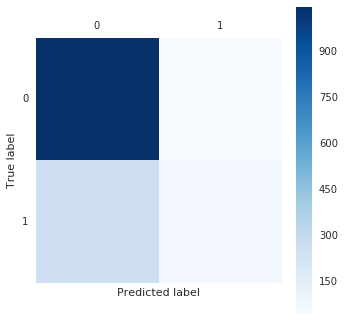

In [46]:
sns.set_style('dark')
cm = confusion_matrix(skinTone, score[2].labels_)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

As expected, even if the BER accuracy is 60%, a lot of points are misclassified. Also, the precision comes mostly from white people correctly classified as white people, which already push the accuracy to 50% even with BER.